In [1]:
import datetime as dt
import os
import sys
sys.path.append(os.pardir)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd

from covid_19.plotting import plot_data
from covid_19 import simulate

        date  confirmed_cases  recovered_cases  death_cases  daily_tests
0 2020-02-26              1.0              0.0          0.0          8.0
1 2020-02-27              3.0              0.0          0.0          8.0
2 2020-02-28              3.0              0.0          0.0          8.0
3 2020-02-29              5.0              0.0          0.0          8.0
4 2020-03-01              6.0              0.0          0.0          8.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases  daily_tests
190 2020-09-03          10725.0           7968.0        191.0       4122.0
191 2020-09-04          11094.0           8266.0        194.0       4492.0
192 2020-09-05          11428.0           8530.0        195.0       4074.0
193 2020-09-06          11739.0           8771.0        197.0       3939.0
194 2020-09-07          11964.0           9008.0        198.0       3509.0


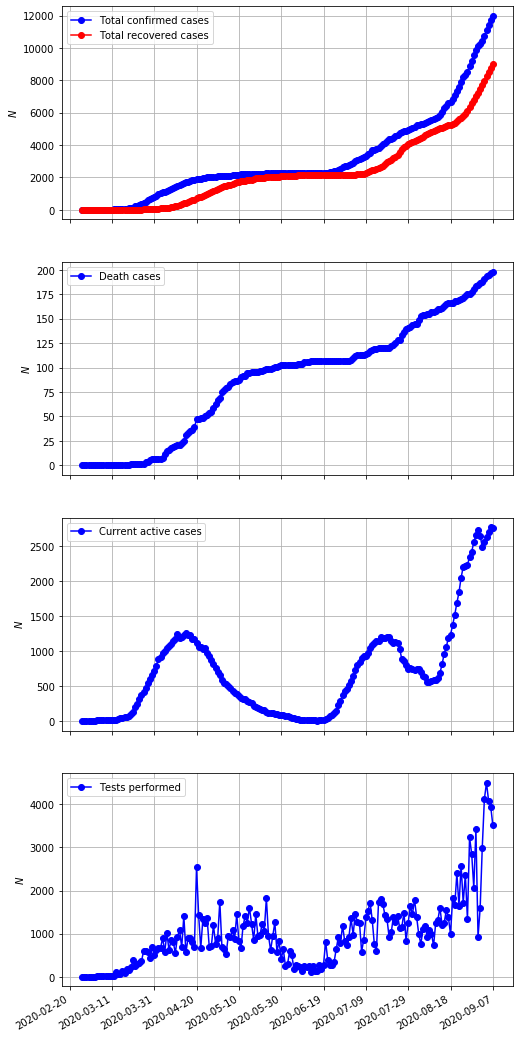

In [2]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
daily_tests = np.loadtxt('../data/tests.dat')

epidemics_start_date = dt.datetime(2020, 2, 26)
date_list = [
    epidemics_start_date + dt.timedelta(days=i) 
    for i in range(confirmed_cases.size)]

# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
    'daily_tests': daily_tests})
print(df.head(), '\n(...)\n', df.tail())

# visualization of full data
plot_data(
    epidemics_start_date,
    df.confirmed_cases,
    df.recovered_cases,
    df.death_cases,
    df.daily_tests)

        date  confirmed_cases  recovered_cases  death_cases  daily_tests
0 2020-06-02           2246.0           2077.0        103.0        290.0
1 2020-06-03           2246.0           2088.0        103.0        602.0
2 2020-06-04           2246.0           2095.0        103.0        517.0
3 2020-06-05           2247.0           2105.0        103.0        183.0
4 2020-06-06           2247.0           2113.0        103.0        270.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases  daily_tests
190 2020-09-03          10725.0           7968.0        191.0       4122.0
191 2020-09-04          11094.0           8266.0        194.0       4492.0
192 2020-09-05          11428.0           8530.0        195.0       4074.0
193 2020-09-06          11739.0           8771.0        197.0       3939.0
194 2020-09-07          11964.0           9008.0        198.0       3509.0


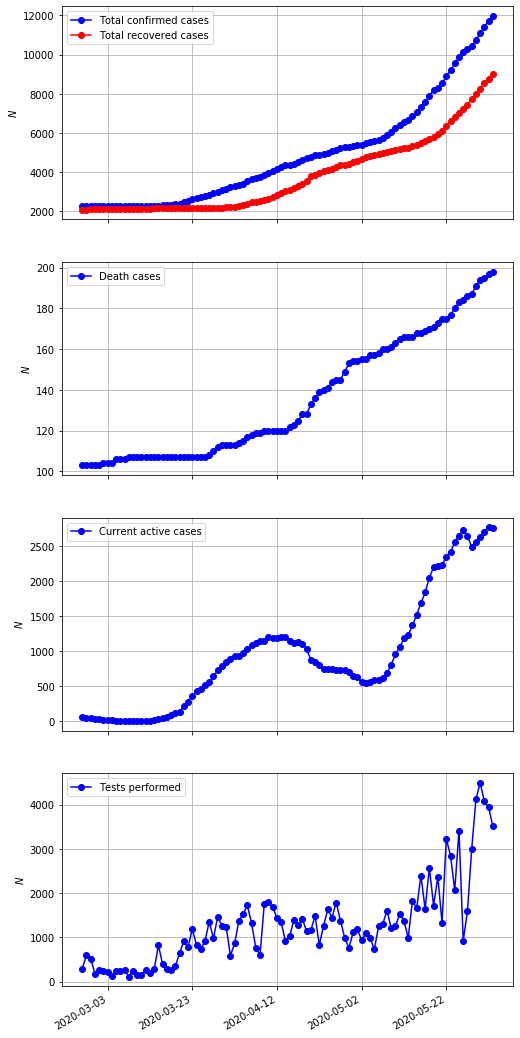

In [3]:
# second wave data dataframe
df2 = df[df.date>dt.datetime(2020, 6, 1)]
df2 = df2.reset_index(drop=True)
print(df2.head(), '\n(...)\n', df.tail())

# visualization
plot_data(
    epidemics_start_date,
    df2.confirmed_cases,
    df2.recovered_cases,
    df2.death_cases,
    df2.daily_tests)

In [4]:
eff_date = dt.datetime(2020, 8, 1)
confirmed_cases = df2[df2.date > eff_date].confirmed_cases.values
daily_tests = df2[df2.date > eff_date].daily_tests.values
n_days = 7

Unfortunatelly, there is no confirmed value of sensitivity and specificity for tests in Croatia (different hospitals) use different tests. Ideal case is when both sensitivity and specificity are 1 (no false classifications). Realistic case is to expect high value of specificity and sensitivity between 72% and 98% [1](https://www.bmj.com/content/bmj/369/bmj.m1808.full.pdf). Since this simulator takes worse case scenario into an account (95% CI lower bound for sensitivity and upper bound for specificity), the simulation performed here uses sensitivity with expected value of 85% (for 95% CI range between 80.75% and 89.25%, where lower value is taken into an  account) and specificity with expected value of 95% (for 95% CI range between 90.25% and 99.75%, where upper value is taken into an account).

Ref.
[1] BMJ 2020;369:m1808 

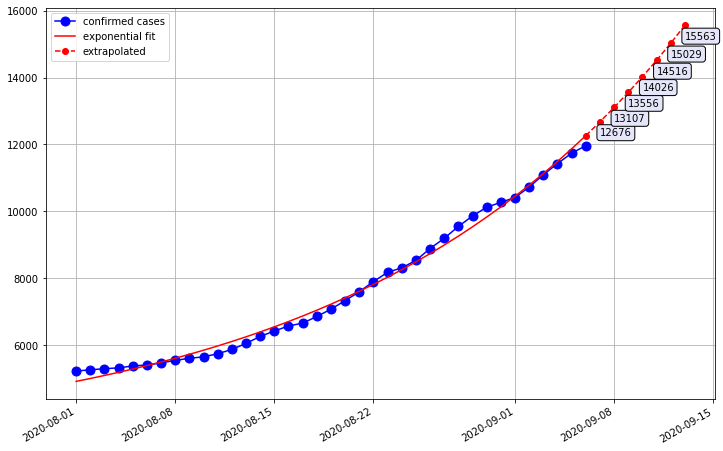

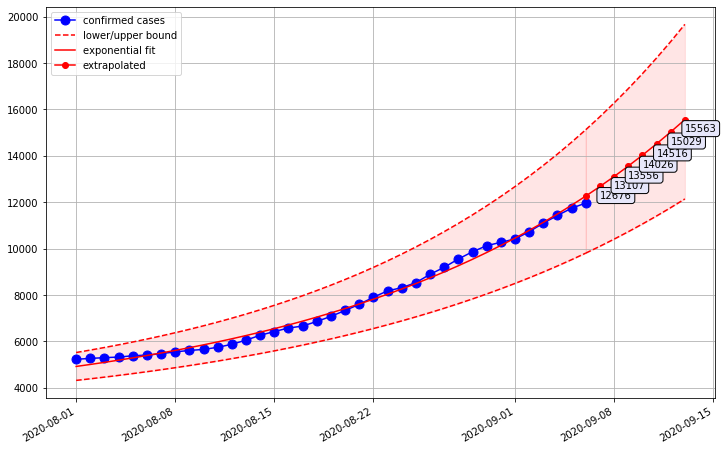

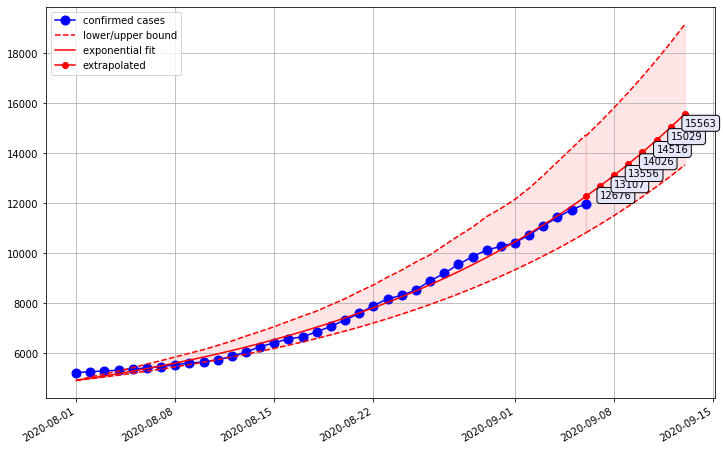

In [5]:
simulate.initial_growth(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days)

simulate.initial_growth(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True)

simulate.initial_growth(
    function='exponential', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True, 
    sensitivity=0.85, 
    specificity=0.95, 
    ci_level=95, 
    daily_tests=daily_tests)

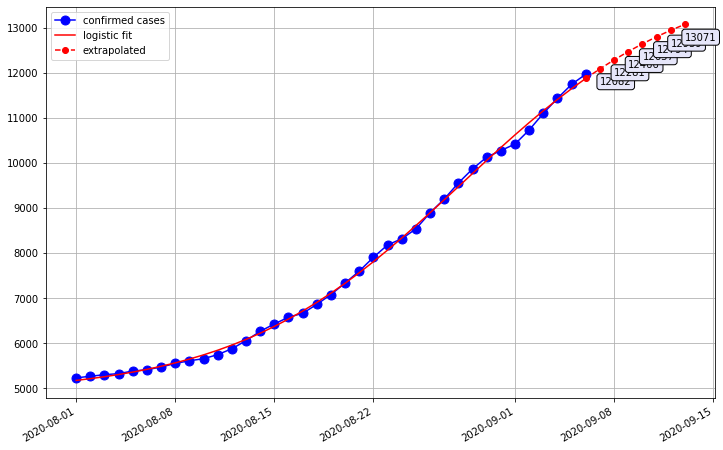

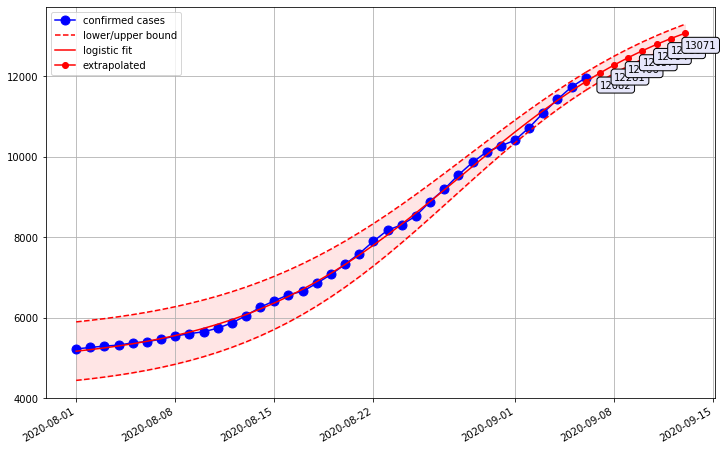

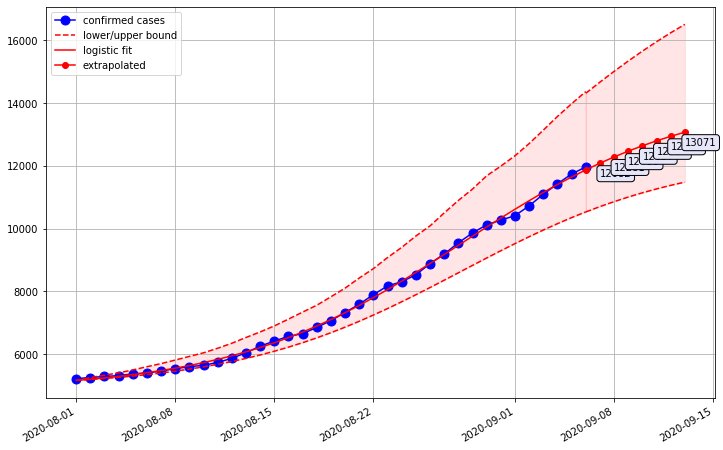

In [6]:
simulate.initial_growth(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days)

simulate.initial_growth(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases,
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True)

simulate.initial_growth(
    function='logistic', 
    eff_date=eff_date, 
    confirmed_cases=confirmed_cases, 
    normalize_data=True,
    n_days=n_days, 
    plot_confidence_intervals=True,
    sensitivity=0.85, 
    specificity=0.95,
    ci_level=95,
    daily_tests=daily_tests)